In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

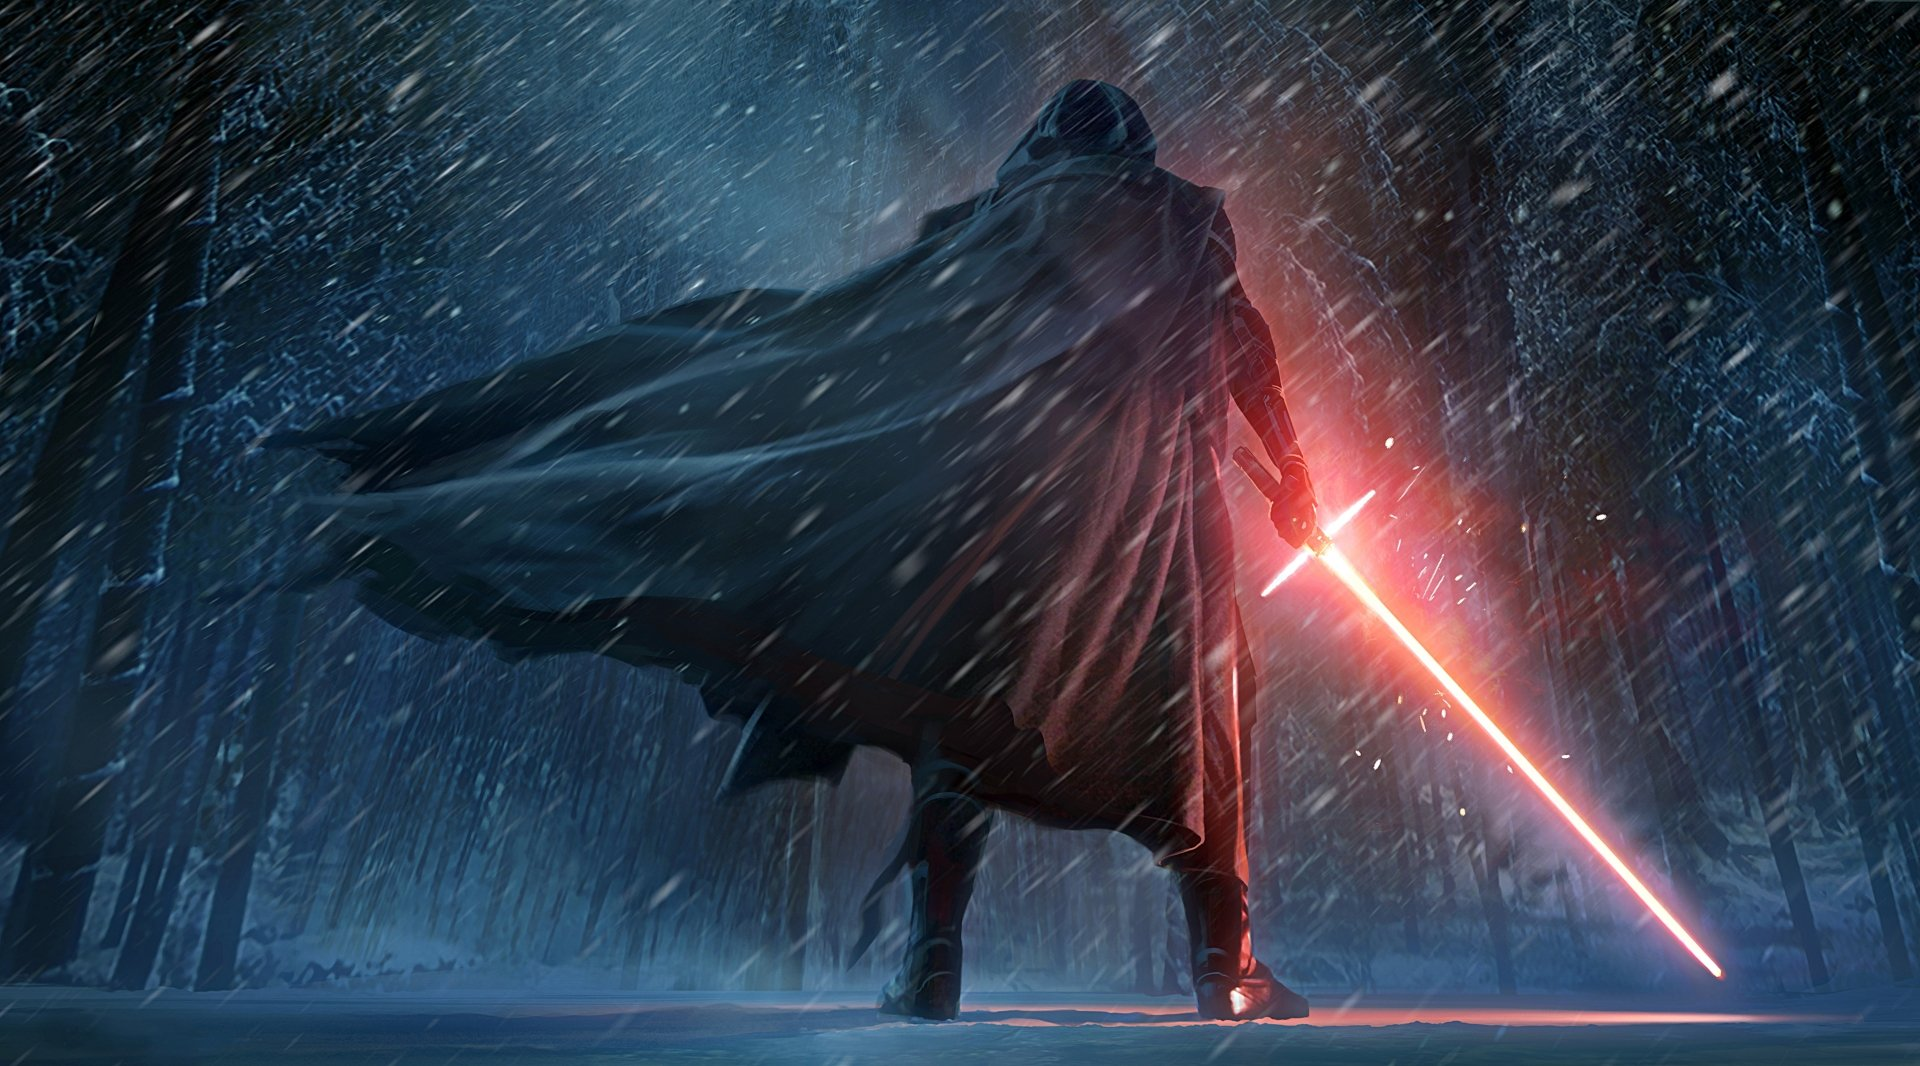

# Importing Modules

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")
plt.style.use("fivethirtyeight")

In [ ]:
df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df.head(10)

In [ ]:
df.tail()

In [ ]:
# rows and columns
df.shape

In [ ]:
# info of dataset
df.info()

In [ ]:
df.isna().sum()

In [ ]:
import missingno as msno
msno.matrix(df)

In [ ]:
df.location.value_counts().head(30)

* Most tweets were from USA

In [ ]:
df.columns

In [ ]:
new_df = df[["text","target"]]
new_df.head(10)

In [ ]:
sns.countplot(df["target"],palette="BuPu")

--------------------

# Resampling Data

In [ ]:
from sklearn.utils import resample
train_majority = df[df.target==0]
train_minority = df[df.target==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
new_df = pd.concat([train_minority_upsampled,train_majority])

In [ ]:
sns.countplot(new_df.target, palette= "BuPu")

------------------

# SpaCy
* spaCy is a free, open-source library for advanced Natural Language Processing (NLP) in Python.
* spaCy is designed specifically for production use and helps you build applications that process and “understand” large volumes of text. 
* It can be used to build information extraction or natural language understanding systems, or to pre-process text for deep learning.

In [ ]:
# Tokenization
spacy_tok = spacy.load("en_core_web_sm")
sample_tweet = new_df.text[105]
sample_tweet

### **Explacy**
* A small tool that explains spaCy parse results

In [ ]:
!wget https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py

In [ ]:
import explacy
explacy.print_parse_info(spacy_tok,"Tornado is very severe in North part of US")

In [ ]:
explacy.print_parse_info(spacy_tok,sample_tweet)

In [ ]:
sentence_spans = list(parsed_tweet)
sentence_spans

In [ ]:
# parsed text representation which shows relation
displacy.render(parsed_tweet,style="dep",jupyter=True,  options={"distance":120})

### **Scattertext**
* A tool for finding distinguishing terms in small-to-medium-sized corpora, and presenting them in a interactive scatter plot with non-overlapping term labels. Exploratory data analysis just got more fun.

In [ ]:
!pip install scattertext
import scattertext as st
nlp = spacy.load('en',disable_pipes=["tagger","ner"])

In [ ]:
new_df.head()

In [ ]:
new_df["parsed"] = new_df.text.apply(nlp)
#corpus = st.CorpusFromParsedDocuments(new_df,category_col="target",parsed_col="parsed").build

In [ ]:
new_df.head()

**SpaCy Text Categorizer:**
* We will train convolutional neural network text classifier on our Coronavirus Tweets using spaCy's new TextCategorizer component.
* SpaCy provides classification model with multiple labels,non_mutually exclusive labels.The TextCategorizer uses its own CNN to balance weights and other pipeline components.

In [ ]:
new_df["tuples"] = new_df.apply(lambda row: (row["text"],row["target"]),axis=1)
train = new_df.tuples.tolist()
train[:5]

-------------------

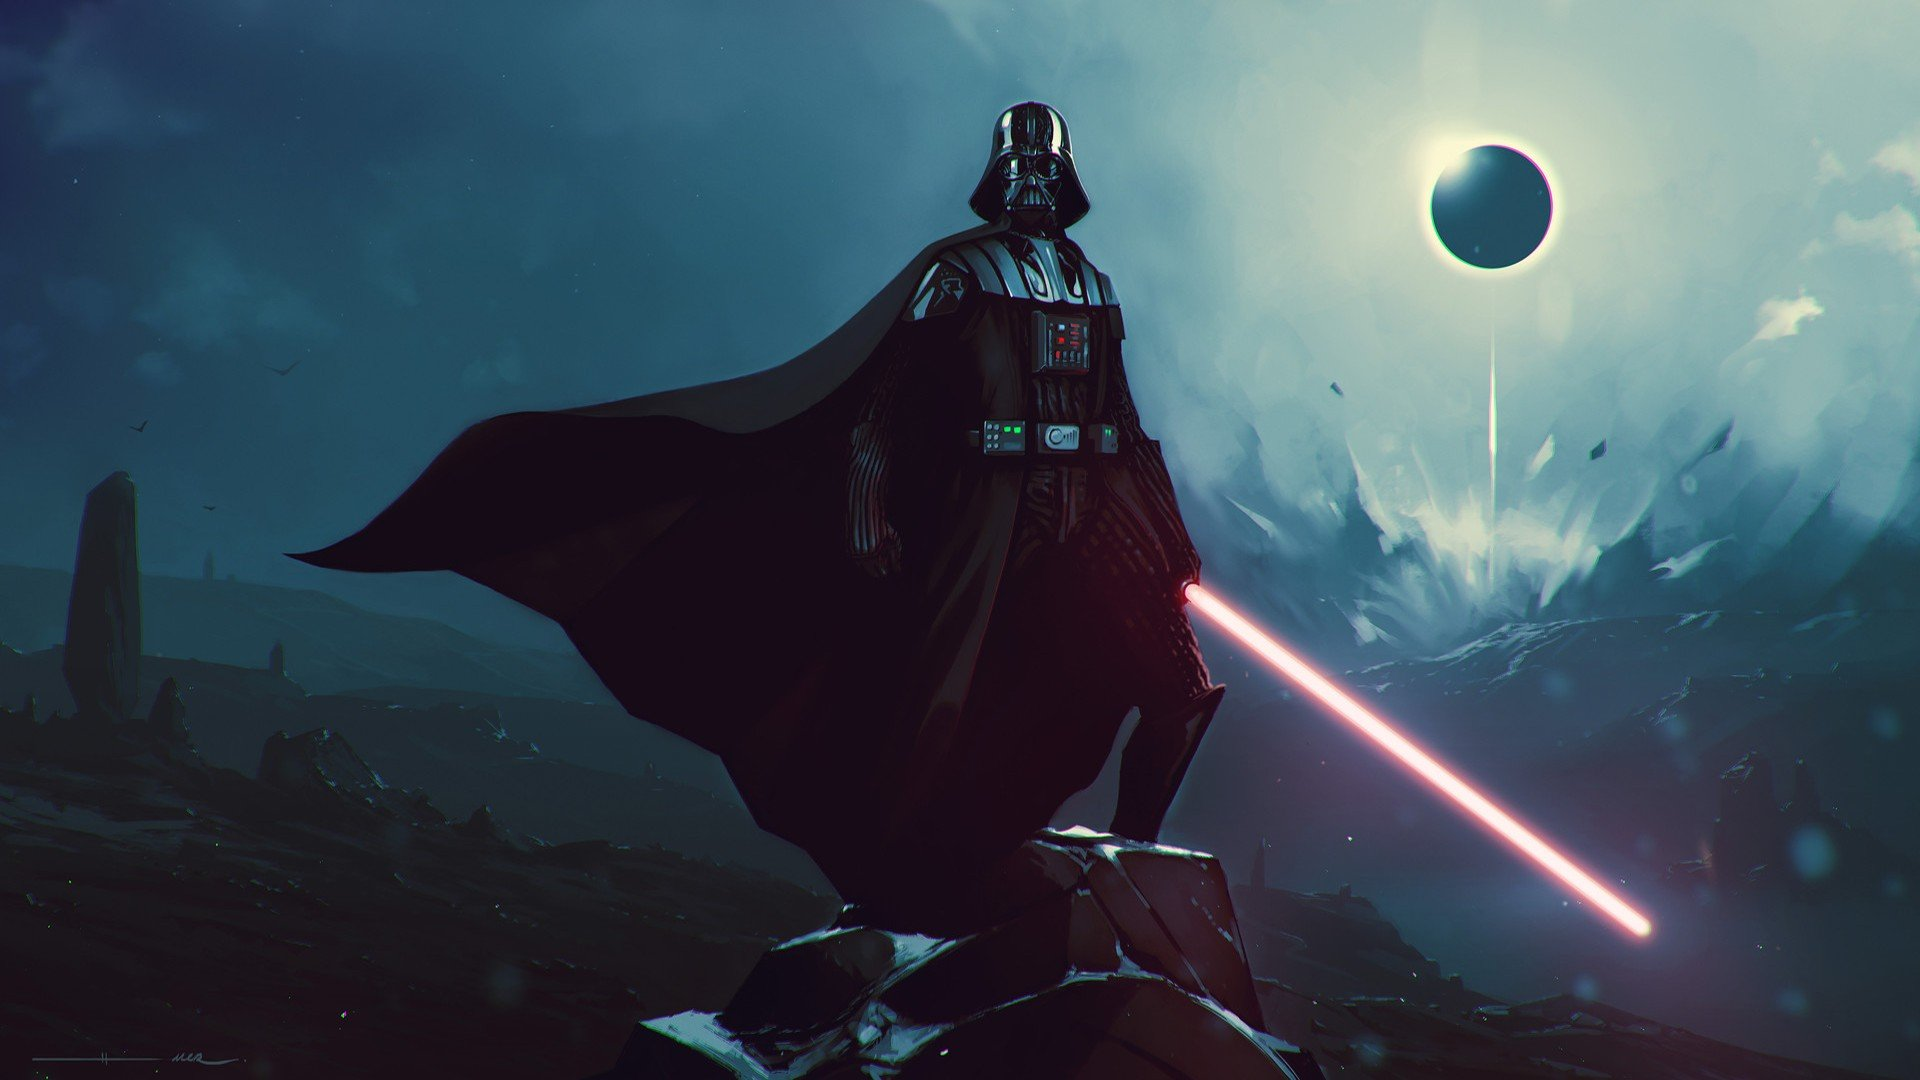

# Model Training

<div class="alert alert-box alert-warning">
Some functions are taken from spaCy documentation.
</div>

* Checkout [this site](https://spacy.io/usage/spacy-101) for more applications of `spaCy`.

In [ ]:
#functions from spaCy documentation
def load_data(limit=0, split=0.8):
    train_data = train
    np.random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

#("Number of texts to train from","t" , int)
n_texts=30000
#You can increase texts count if you have more computational power.

#("Number of training iterations", "n", int))
n_iter=10

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
# add the text classifier to pipeline if it doesn't
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat,last=True)
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier
textcat.add_label("POSITIVE")

# load the data
print("Loading the Disaster Tweets...")
(train_texts, train_cats),(dev_texts, dev_cats) = load_data(limit=n_texts)
print("Using {} examples ({} training {} evaluation)".format(n_texts, len(train_texts),len(dev_texts)))
train_data = list(zip(train_texts,[{'cats': cats} for cats in train_cats]))

In [ ]:
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))

**Testing our model through random inputs:**

In [ ]:
test_text1 = "Earthquake is affecting Japan since 1956"
test_text2 = "Coronavirus is not anymore in Delhi."
doc = nlp(test_text1)
test_text1, doc.cats

In [ ]:
doc2 = nlp(test_text2)
test_text2, doc2.cats

In [ ]:
test_text3 = new_df.text[96]
test_text3

In [ ]:
doc3 = nlp(test_text3)
test_text3, doc3.cats

In [ ]:
test_text4 = new_df.text[66]
test_text4

In [ ]:
doc4 = nlp(test_text4)
test_text4, doc4.cats

In [ ]:
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
df_test.head(4)

In [ ]:
test_text5 = df_test.text[3]
test_text5

In [ ]:
doc5 = nlp(test_text5)
test_text5, doc5.cats

<div class="alert alert-box alert-info">
Our SpaCy model is working fine. 
    
We can try predicting with test data also.
</div>

<div class="alert alert-box alert-warning">
UPVOTE if you find this kernel insighful! This helps me stay motivated😊.
    
See ya!
</div>